In [34]:
# 1) Instalar e imports
!pip install catboost --quiet

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import pandas as pd
file_path = "/content/drive/MyDrive/Dataset Idealista/pisosBarcelona-21-04-2025-clean.csv"
df = pd.read_csv(file_path, encoding='latin1')

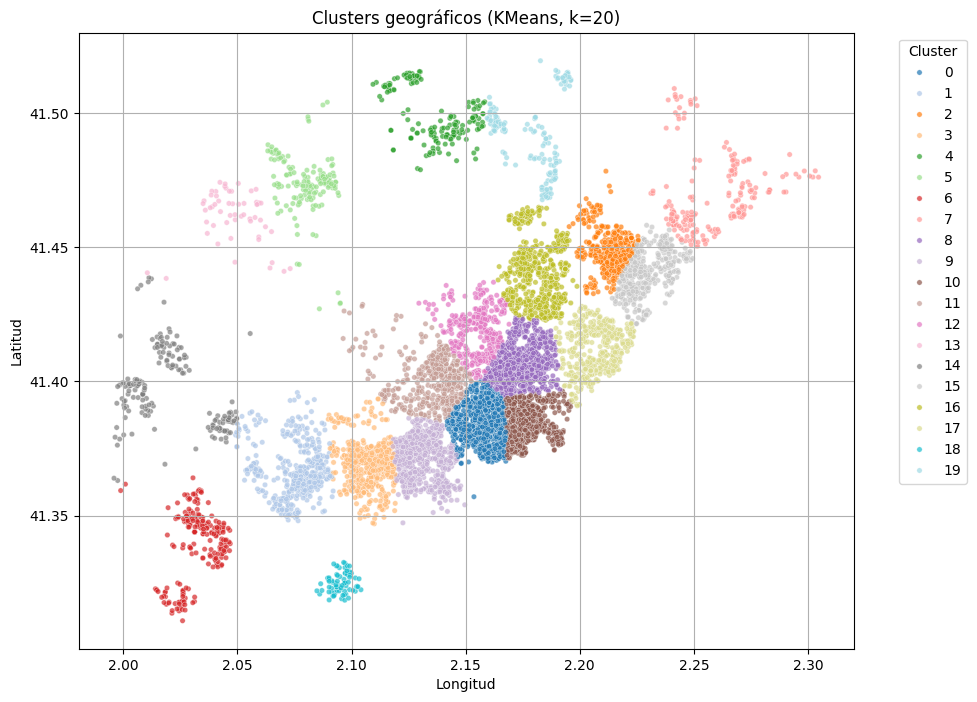

In [37]:
# 3) Clustering geográfico con visualización
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 3.1 Preparar las coordenadas y rellenar NaNs
coords = df[["latitude", "longitude"]].copy()
coords.fillna(coords.mean(), inplace=True)

# 3.2 Entrenar KMeans
k = 20  # ajusta según validación (silhouette, etc.)
km = KMeans(n_clusters=k, random_state=42)
df["geo_cluster"] = km.fit_predict(coords)

# 3.3 Visualizar los clusters en un scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df,
    x="longitude", y="latitude",
    hue="geo_cluster",
    palette="tab20",   # paleta discreta para hasta 20 clusters
    s=15,              # tamaño de los puntos
    alpha=0.7,
    legend="full"
)
plt.title(f"Clusters geográficos (KMeans, k={k})")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()



In [38]:
# 4) Estadísticas agregadas por district
# 4.1 Media de precio por district
mean_price_district = df.groupby("district")["price"].mean()
df["mean_price_district"] = df["district"].map(mean_price_district)
# 4.2 Recuento de anuncios por district
count_district = df["district"].value_counts()
df["count_district"] = df["district"].map(count_district)
# Rellenar posibles NaNs con globales
df["mean_price_district"].fillna(df["price"].mean(), inplace=True)
df["count_district"].fillna(0, inplace=True)


<ipython-input-38-145012de0f78>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["mean_price_district"].fillna(df["price"].mean(), inplace=True)
<ipython-input-38-145012de0f78>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpla

In [39]:
# 5) Definir variables a usar
numerical_cols = [
    "size", "rooms", "bathrooms", "latitude", "longitude", "numPhotos",
    "geo_cluster", "mean_price_district", "count_district"
]

categorical_cols = [
    "propertyType", "operation", "floor",
    "exterior", "province", "municipality",
    "district", "neighborhood", "status",
    "hasLift", "newDevelopment"
]


In [40]:
# 6) Imputación y conversión de dtypes
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df[col] = df[col].fillna(df[col].median())

for col in categorical_cols:
    df[col] = df[col].astype(str).fillna("missing")


In [41]:
# 7) División de los datos
X = df[numerical_cols + categorical_cols]
y = df["price"]

# 7.1 Interpolación vs extrapolación (80/20, sin shuffle)
X_inter, X_extra, y_inter, y_extra = train_test_split(
    X, y, test_size=0.20, shuffle=False, random_state=42
)

# 7.2 Train/Test dentro de interpolación (80/20 con shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X_inter, y_inter, test_size=0.20, random_state=42
)


In [42]:
# 8) Entrenar CatBoost
cat_features_idx = [X_train.columns.get_loc(col) for col in categorical_cols]

model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function="RMSE",
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)

model.fit(
    X_train, y_train,
    cat_features=cat_features_idx,
    eval_set=(X_test, y_test)
)


0:	learn: 529003.4478633	test: 515117.0530177	best: 515117.0530177 (0)	total: 57.8ms	remaining: 57.7s
100:	learn: 209760.8473168	test: 219503.2677194	best: 219503.2677194 (100)	total: 3.67s	remaining: 32.7s
200:	learn: 166609.0946589	test: 193010.9103686	best: 193010.9103686 (200)	total: 7.17s	remaining: 28.5s
300:	learn: 145470.3167841	test: 185664.1617514	best: 185577.1758369 (298)	total: 11.5s	remaining: 26.8s
400:	learn: 131013.5228643	test: 182009.8618041	best: 182009.8618041 (400)	total: 16.6s	remaining: 24.8s
500:	learn: 121120.3399044	test: 180197.7456565	best: 180185.5947444 (499)	total: 19.6s	remaining: 19.5s
600:	learn: 114267.4342157	test: 179796.2219598	best: 179597.9194851 (571)	total: 20.9s	remaining: 13.9s
700:	learn: 107984.2191779	test: 179016.3909446	best: 178962.9107631 (692)	total: 22.2s	remaining: 9.47s
800:	learn: 102542.4640346	test: 178261.9018628	best: 178261.9018628 (800)	total: 23.5s	remaining: 5.84s
900:	learn: 97838.9450197	test: 177408.2984254	best: 17740

In [43]:
# 9) Evaluación
def eval_set(name, X_, y_):
    p = model.predict(X_)
    mae  = mean_absolute_error(y_, p)
    rmse = np.sqrt(mean_squared_error(y_, p))
    r2   = r2_score(y_, p)
    print(f"{name}: MAE={mae:.0f}, RMSE={rmse:.0f}, R²={r2:.4f}")

print("\n📊 Resultados CatBoost mejorado:")
eval_set("▶ Test (Interpolación)",   X_test,  y_test)
eval_set("▶ Extrapolación",         X_extra, y_extra)



📊 Resultados CatBoost mejorado:
▶ Test (Interpolación): MAE=86671, RMSE=176913, R²=0.8893
▶ Extrapolación: MAE=89196, RMSE=199557, R²=0.8396


In [45]:
import os
import joblib

# Ruta donde quieres guardar
output_dir = "/content/drive/MyDrive/ModelosIdealista"
os.makedirs(output_dir, exist_ok=True)

# Serializar el modelo CatBoost
model_path = os.path.join(output_dir, "catboost_model.pkl")
joblib.dump(model, model_path)

print(f"✅ Modelo guardado en: {model_path}")

✅ Modelo guardado en: /content/drive/MyDrive/ModelosIdealista/catboost_model.pkl
